In [ ]:
!sudo apt install ffmpeg # Install ffmpeg to save video output

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!nvidia-smi

Fri Dec 30 11:56:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torch.optim import Optimizer
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(
    format="%(asctime)s %(message)s", 
    datefmt="%m/%d/%Y %I:%M:%S %p %Z",
    level = logging.INFO
)

In [ ]:
class AdamOptimizer(Optimizer):
    """
    implements ADAM Algorithm, as a preceding step.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamOptimizer, self).__init__(params, defaults)
        
    def step(self):
        import math
        """
        Performs a single optimization step.
        """
        loss = None
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Momentum (Exponential MA of gradients)
                    state['exp_avg'] = torch.zeros_like(p.data)
                    #print(p.data.size())
                    # RMS Prop componenet. (Exponential MA of squared gradients). Denominator.
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # L2 penalty. Gotta add to Gradient as well.
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Momentum
                exp_avg = torch.mul(exp_avg, b1) + (1 - b1)*grad
                # RMS
                exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(grad*grad)
                
                denom = exp_avg_sq.sqrt() + group['eps']

                bias_correction1 = 1 / (1 - b1 ** state['step'])
                bias_correction2 = 1 / (1 - b2 ** state['step'])
                
                adapted_learning_rate = group['lr'] * bias_correction1 / math.sqrt(bias_correction2)

                p.data = p.data - adapted_learning_rate * exp_avg / denom 
                
        return loss

class SgdOptimizer(Optimizer):
    """Implements SGD Algorithm
    The Nesterov version can be performed by choosing input argument
    """
    def __init__(self, 
        params, 
        lr=1e-3, 
        momentum=0, 
        dampening=0,
        weight_decay=0, 
        nesterov=False):

        defaults = dict(lr=lr, momentum=momentum,
                        dampening=dampening,
                        weight_decay=weight_decay, 
                        nesterov=nesterov)

        super(SgdOptimizer, self).__init__(params, defaults)

    def step(self):
        loss = None
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def show_img(x, epoch):
    grid_img = torchvision.utils.make_grid(x, nrow = 16)
    fig, ax = plt.subplots(figsize = (10, 15))
    ax.imshow(grid_img.permute(1, 2, 0))
    ax.set(xticks = [], yticks = [])
    plt.title(f'Epoch = {epoch}')
    fig.savefig(f'{epoch}.png', bbox_inches='tight')
    plt.show()
    
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MNIST('./data', transform=img_transform, download=True,)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
eval_batch = next(iter(dataloader))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
model = AutoEncoder().cuda()
criterion = nn.MSELoss()
optimizer = SgdOptimizer(model.parameters(), lr=learning_rate, momentum=0.96, weight_decay=1e-5, nesterov=True)


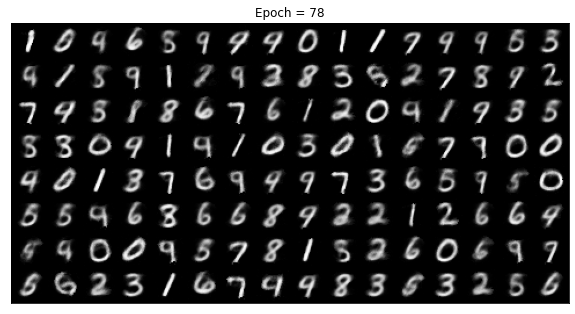

Epoch [78/100]:  17%|█▋        | 82/469 [00:02<00:13, 29.61it/s, loss=0.148]

In [ ]:
from IPython.display import clear_output
for epoch in range(num_epochs):
    recon_loss = 0.0
    iterator = tqdm(dataloader, leave=True)
    model.train()
    for data in iterator:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        recon_loss += loss.item()

        # Progress bar
        iterator.set_description('Epoch [{}/{}]'.format(epoch, num_epochs))
        iterator.set_postfix(loss=loss.item())
        
    recon_loss /= len(dataloader)
    print(f">> Epoch {epoch}: Recon loss = {recon_loss}")
    # if epoch % 10 == 0:
    #     pic = to_img(output.cpu().data)
    #     save_image(pic, './mlp_img/image_{}.png'.format(epoch))

    # =================== Validation ==================
    clear_output(wait=True)
    model.eval()
    val_img, _ = eval_batch
    val_img = val_img.view(val_img.size(0), -1)
    val_img = Variable(val_img).cuda()
    with torch.no_grad():
        val_output = model(val_img)
        val_loss = criterion(val_output, val_img)
        # save result
        valpic = to_img(val_output.cpu().data)
        show_img(valpic, epoch + 1) 
        #save_image(valpic, '{}.png'.format(epoch+1))

In [ ]:
!cat $(find . -maxdepth 1 -name "*.png" | sort -V) | ffmpeg -framerate 10 -i - output.avi

In [ ]:
!ffmpeg -i output.avi -pix_fmt gray animation.gif